In [77]:
import os
import configuration as cfg
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import copy
import albumentations as A
import random


import torch
from torchvision import transforms


In [133]:
    

color_dict = {
    'person': (255, 0, 0), # red 
    'people': (0, 255, 0), # green
    'cyclist':(0, 0, 255), # blue
}


def GaussianBlur(rgb_img, ir_img, box, kernel=(5, 55)):
    rgb_after = cv2.GaussianBlur(rgb_img, kernel, 0)
    ir_after = cv2.GaussianBlur(ir_img, kernel, 0)
    return rgb_after, ir_after, box 


def GaussianNoise(rgb_img, ir_img, box):
    row,col,ch= rgb_img.shape
    mean = 0
    var = 0.01
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)

    normalized_rgb = cv2.normalize(rgb_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_ir = cv2.normalize(ir_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    rgb_after = np.add(normalized_rgb, gauss) * 255
    ir_after = np.add(normalized_ir, gauss) * 255

    # print('shape rgb before after ', rgb_img.shape, rgb_after.shape)
    # print('type ', type(gauss), type(rgb_img), type(rgb_after))
    # print('gauss ', gauss[12][0])
    # print('rgb ', normalized_rgb[12][0])
    # print('rgb after ', rgb_after[12][0])

    return rgb_after, ir_after, box



def ColorJittering(rgb_img, ir_img, box, color_aug_tuple=('brightness', 1)):

    if color_aug_tuple[0] == 'brightness':
        color_transform = transforms.ColorJitter(brightness=color_aug_tuple[1])
    elif color_aug_tuple[0] == 'contrast':
        color_transform = transforms.ColorJitter(contrast=color_aug_tuple[1])
    elif color_aug_tuple[0] == 'saturation':
        color_transform = transforms.ColorJitter(saturation=color_aug_tuple[1])
    elif color_aug_tuple[0] == 'hue':
        color_transform = transforms.ColorJitter(hue=color_aug_tuple[1])
    else:
        raise('need a valid option')

    rgb_pil_format = Image.fromarray(rgb_img)
    ir_pil_format = Image.fromarray(ir_img)

    rgb_pil_format = color_transform(rgb_pil_format)
    ir_pil_format = color_transform(ir_pil_format)

    rgb_after = np.asarray(rgb_pil_format)
    ir_after = np.asarray(ir_pil_format)

    return rgb_after, ir_after, box

def HorizontalFlip(rgb_img, ir_img, bboxes):

    rgb_after = cv2.flip(rgb_img, 1)
    ir_after = cv2.flip(ir_img, 1)

    img_center = np.array(rgb_img.shape[:2])[::-1]//2
    img_center = np.hstack((img_center, img_center))
    bboxes[:,[0,2]] += 2*(img_center[[0,2]] - bboxes[:,[0,2]])
    box_w = abs(bboxes[:,0] - bboxes[:,2])
    bboxes[:,0] -= box_w
    bboxes[:,2] += box_w
    
    return rgb_after, ir_after, bboxes 
    

class Data_Process():
    def __init__(self, annotation_path, augmenation=None):
        super(Data_Process,self).__init__()
        self.annotation_path = annotation_path  
        self.augmenation = augmenation
        # print(augmenation)

    def show_image(self, image1, image2, image3, image4):
        f, axarr = plt.subplots(1,4, figsize=(32, 40))
        axarr[0].imshow(image1)
        axarr[1].imshow(image2)
        axarr[2].imshow(image3)
        axarr[3].imshow(image4)
        plt.title('data')
        plt.show()
        pass
    
    def pre_process_img(self):
        for annot_file_name in os.listdir(self.annotation_path):
            file_id = annot_file_name.split('.txt')[0]
            annot_file = os.path.join(self.annotation_path, annot_file_name)
            rgb_img_path = os.path.join(cfg.rgb_imgs, file_id+'.png')
            ir_img_path = os.path.join(cfg.ir_imgs, file_id+'.png')
            rgb_img = cv2.imread(rgb_img_path)
            ir_img = cv2.imread(ir_img_path)
            # print(rgb_img.shape, ir_img.shape)
            
            rgb_before = copy.deepcopy(rgb_img)
            ir_before = copy.deepcopy(ir_img)

            # Read File
            with open(annot_file, 'r') as f:
                objs = f.readlines()[1:]
            boxes = []
            names = []
            for ix, obj in enumerate(objs):
                obj_split = obj.split(' ')
                #obj_count += 1
                name = str(obj_split[0])
                x1 = int(obj_split[1])
                y1 = int(obj_split[2])
                x2 = x1 + int(obj_split[3])
                y2 = y1 + int(obj_split[4])
                boxes.append([x1, y1, x2, y2])
                names.append(name)

            boxes = np.asarray(boxes)
            boxes_before = copy.deepcopy(boxes)
            print("annotations: ",boxes, boxes.shape)


            ######Augmentation implementation
            aug_rgb_img, aug_ir_img, updated_boxes = self.augmenation(rgb_before, ir_before, boxes_before)
            ################

            for i in range(len(names)):
                box = boxes[i]
                color = color_dict[names[i]]
                cv2.rectangle(rgb_img, (box[0], box[1]), (box[2], box[3]), color, 2)
                cv2.rectangle(ir_img, (box[0], box[1]), (box[2], box[3]), color, 2)
                
            for i in range(len(updated_boxes)):
                box = updated_boxes[i]
                # color = color_dict[names[i]]
                cv2.rectangle(aug_rgb_img, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 2)
                cv2.rectangle(aug_ir_img, (box[0], box[1]), (box[2], box[3]), (255, 255, 255), 2)

            self.show_image(rgb_img, ir_img, aug_rgb_img, aug_ir_img)

            # break




annotations:  [[567 232 605 325]
 [176 215 197 264]
 [218 218 238 261]
 [127 206 151 254]
 [112 205 135 255]] (5, 4)
array  [3534 1029  860 1152 1150]


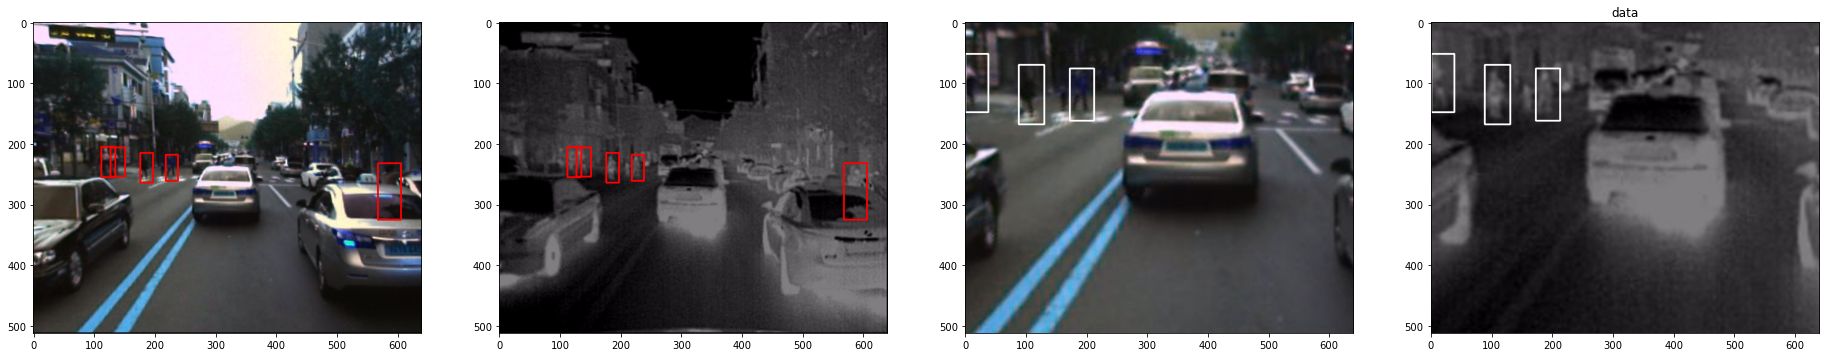

annotations:  [[331 212 361 281]
 [280 214 303 261]] (2, 4)
array  [2070 1081]


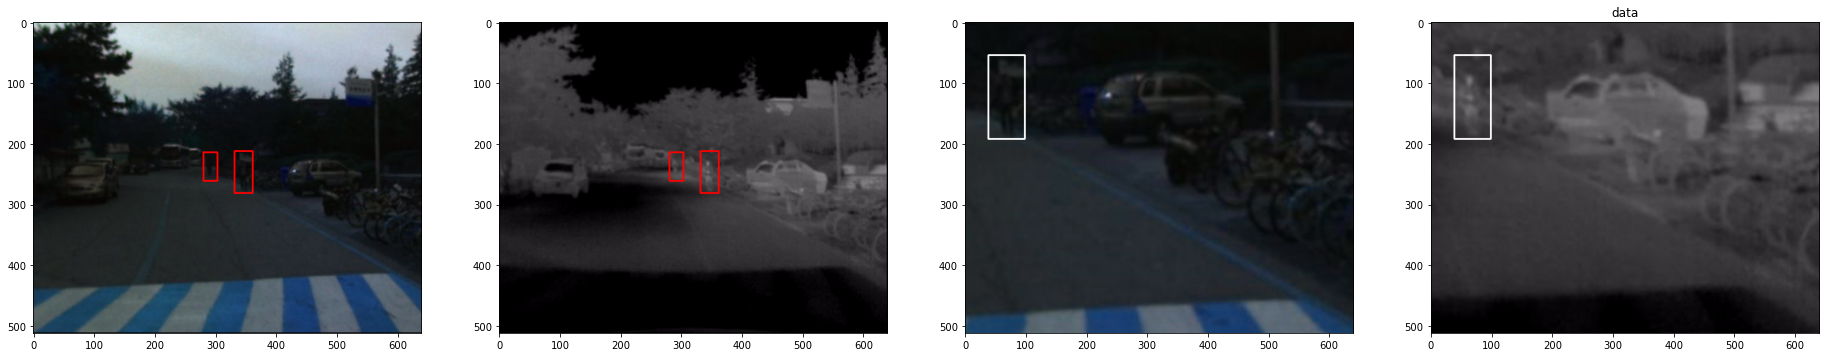

annotations:  [[494 214 551 362]
 [525 235 604 387]
 [447 218 493 342]
 [176 202 525 259]] (4, 4)
array  [ 8436 12008  5704 19893]


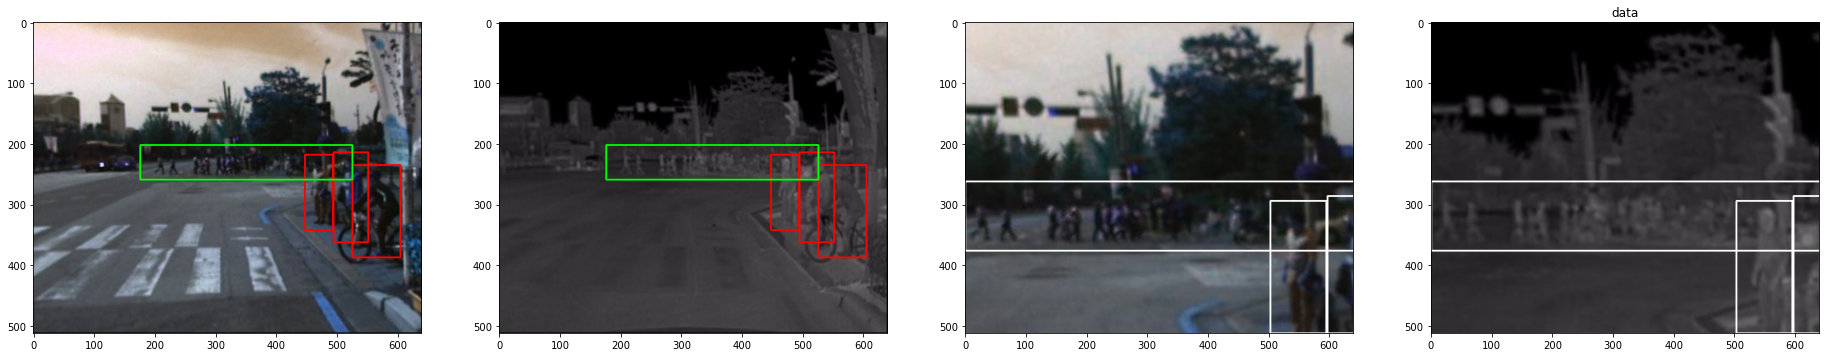

annotations:  [[ 62 218 128 391]
 [111 292 156 389]
 [149 222 207 339]
 [539 202 628 304]
 [335 202 525 259]] (5, 4)
array  [11418  4365  6786  9078 10830]


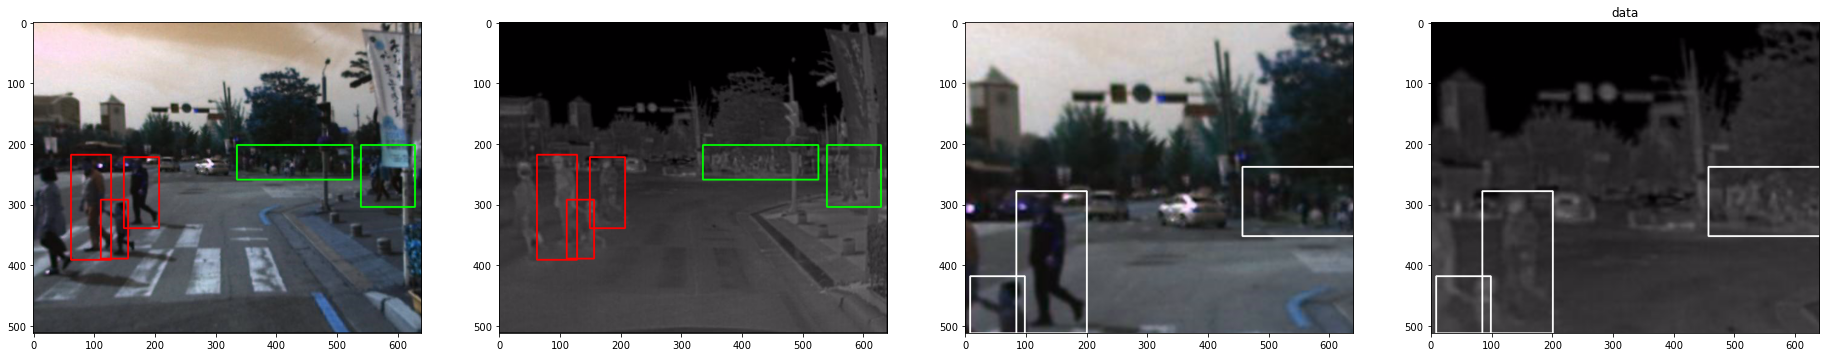

annotations:  [[580 228 602 281]
 [617 227 639 285]
 [443 224 476 316]
 [499 222 531 325]
 [224 224 265 321]
 [407 214 443 251]] (6, 4)
array  [1166 1276 3036 3296 3977 1332]


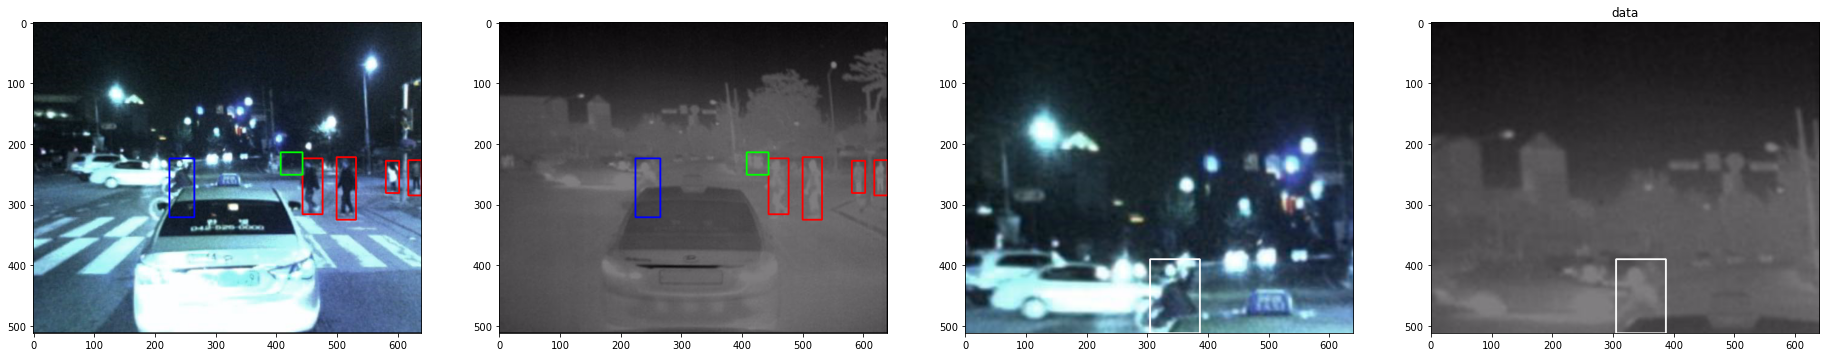

annotations:  [[580 228 602 281]
 [617 227 639 285]
 [226 218 283 324]
 [154 209 206 352]
 [407 214 427 251]] (5, 4)
array  [1166 1276 6042 7436  740]


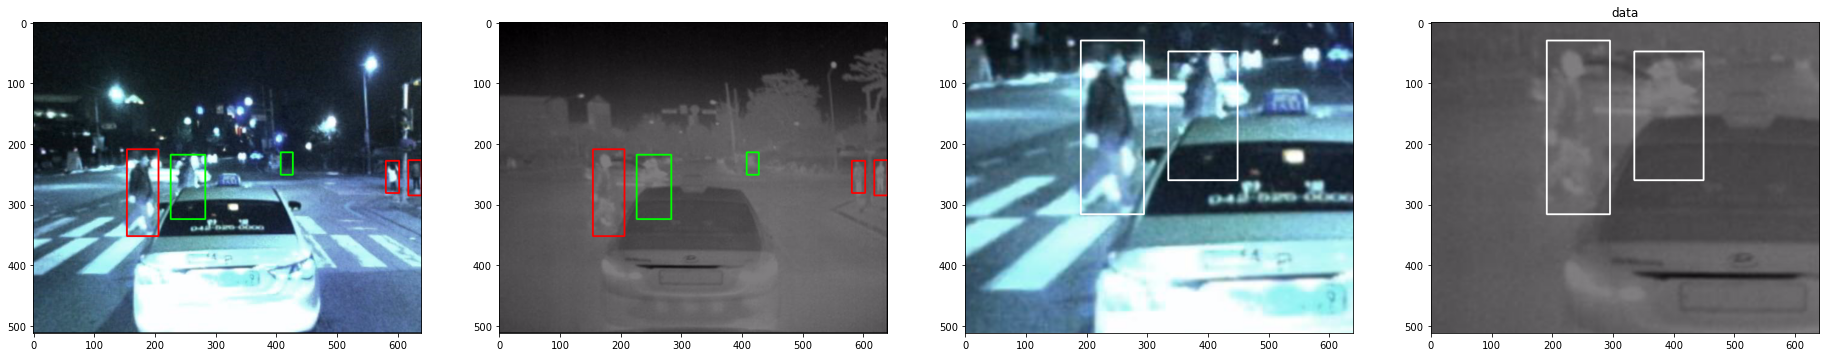

In [138]:
from torch import float64


def bbox_area(bbox):

    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

def clip_box(bbox, clip_box, alpha):

    # print(bbox, clip_box, alpha)
    ar_ = bbox_area(bbox)

    print('array ', ar_)
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]

    return bbox

def RandomCrop(rgb_img, ir_img, bboxes, ratio=0.5):

    inv_ratio = 1/ratio
    h, w, c = rgb_img.shape

    start_h, start_w, c = int(h*ratio//2), int(w*ratio//2), c
    end_h = h - start_h
    end_w = w - start_w

    center_w = random.randint(start_w, end_w)
    center_h = random.randint(start_h, end_h)

    left_top_x = center_w - start_w
    left_top_y = center_h - start_h

    bottom_right_x = center_w + start_w
    bottom_right_y = center_h + start_h

    # cv2.rectangle(cropped_image_temp, (left_top_x, left_top_y), (bottom_right_x, bottom_right_y), (255, 255, 0), 2)

    cropped_image_rgb = rgb_img[left_top_y:bottom_right_y, left_top_x:bottom_right_x]
    cropped_image_rgb = cv2.resize(cropped_image_rgb, (w, h))

    cropped_image_ir = ir_img[left_top_y:bottom_right_y, left_top_x:bottom_right_x]
    cropped_image_ir = cv2.resize(cropped_image_ir, (w, h))

    new_box = clip_box(bboxes, [left_top_x, left_top_y, bottom_right_x, bottom_right_y], 0.25)
    # print('new boxes ', new_box)

    new_box[:, :4] -= [left_top_x, left_top_y, left_top_x, left_top_y]
    new_box = np.asarray(new_box, dtype=np.float64)
    new_box[:, :4] *= [inv_ratio, inv_ratio, inv_ratio, inv_ratio]
    new_box = np.asarray(new_box, dtype=np.int64)
    # print('new boxes after ', new_box)

    return cropped_image_rgb, cropped_image_ir, new_box




data_process = Data_Process(cfg.annotation_path, augmenation=RandomCrop) ###pass your augmentation object here instead of None
data_process.pre_process_img()


In [ ]:
# if __name__=="__main__":
#     ###########We need to implement augmentation class
#     #augmentation = Augmentation()
#     ################################
#     data_process = Data_Process(cfg.annotation_path, augmenation=None) ###pass your augmentation object here instead of None
#     data_process.pre_process_img()